<a href="https://colab.research.google.com/github/ucoskun/bloch-torrey-pinn/blob/main/bloch_torrey_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install deepXDE**  
Tensorflow and all other dependencies are already installed in Colab terminals

In [1]:
!pip install deepxde;
import numpy as np

import deepxde as dde
from deepxde.backend import tf
# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# For cleaning the messy deepXDE installation output
from IPython.display import clear_output
clear_output()


**References:**

**[1]** Kenkre et. al. Simple Solutions of the Torrey–Bloch Equations
in the NMR Study of Molecular Diffusion : https://physics.unm.edu/kenkre/papers/Art164.pdf



---

# **Solving Torrey-Bloch Equations via Physics-Informed Neural Networks (PINNs)**

Trying to reproduce the results in **[1]** using PINNs (deepxde library)

Bloch-Torrey equation for the magnetization density $M(\mathbf{r},t)$ with diffusion coefficient $D$ and arbitrary time-dependent liear gradient field is

$$M_t(\mathbf{r},t) = -igf(t)xM(\mathbf{r},t) + D\nabla^2M(\mathbf{r},t)$$

In 1-D

$$M_t(x,t) = -igf(t)xM(x,t) + D M_{xx}(x,t)$$

NMR signal is defined by

$$M(t) = \int_{-∞}^∞ M(x,t)dx$$

Denoting real and imaginary parts of $M(x,t) = u(x, t) + iv(x, t)$ we have

$$u_t - v(x, t) g f(t) x - Du_{xx}=0$$
$$v_t + u(x, t) g f(t) x - Dv_{xx}=0$$

where $f(x)$ is the envelope function of the external magnetic field.

# Case (iii) : Nonuniform Initial Density

Since we consider constant gradient we will set $f(t) = 1$.

First consider an initial square distribution

$$t\in [0, 3]$$

$$M(x, 0) = 1/L, x\in [-L/2, L/2]$$ otherwise 0.

Let's set $g=D=1$ so we have $T=(Dg^2)^{1/3}t = t$ and the parameter $p \equiv (g/D)^{1/3}L = L = 0, 2, 5, 20$.

The analytical solution is (Eq. (16) of **[1]**)
$$M(t) = \frac{\sin(tL/2)}{tL/2}e^{-t^3/3}$$

Let's plot it

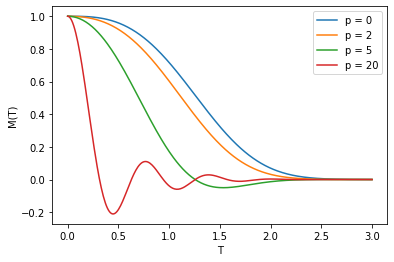

In [2]:
time = np.linspace(0, 3, 300) # This time is used only for plotting the
                                   # analytical solution

def M_T(L, t):
    return np.sinc(t * L / (2 * np.pi)) * np.exp(-t**3 / 3)

plt.plot(time, M_T(0, time), label = "p = 0")
plt.plot(time, M_T(2, time), label = "p = 2")
plt.plot(time, M_T(5, time), label = "p = 5")
plt.plot(time, M_T(20, time), label = "p = 20")

plt.xlabel("T")
plt.ylabel("M(T)")
plt.legend()

In [3]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_t = 1
    f_u = (u_t - v * f_t * x[:, 0:1] - u_xx)
    f_v = (v_t + u * f_t * x[:, 0:1] - v_xx)

    return [f_u, f_v]

In [4]:
L = 20

In [5]:
def time_piece_train(t_lower, t_upper):
    # Set x domain size randomly

    x_range = L/2
    x_lower = -x_range
    x_upper = x_range

    # Creation of the 2D domain (for plotting and input, not for training!)
    x_size = 1000
    t_size = 1000
    x = np.linspace(x_lower, x_upper, x_size)
    t = np.linspace(t_lower, t_upper, t_size)
    X, T = np.meshgrid(x, t)

    # The whole domain flattened (again only for prediction, not for training)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

    # Space and time domains/geometry (for the deepXDE model)
    space_domain = dde.geometry.Interval(x_lower, x_upper)
    time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
    geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
    data = dde.data.TimePDE(
    geomtime,
    pde,
    [],
    num_domain=20000,
    num_initial=0,
    train_distribution="uniform"
    )

    def modify_output(x, y):
        u, v = y[:, 0:1], y[:, 1:2]
        u_new = (x[:, 1:2] - t_lower) * u + tf.ones_like(x[:, 0:1])
        v_new = (x[:, 1:2] - t_lower) * v
        return tf.concat((u_new, v_new), axis=1)

    # Network architecture
    net = dde.nn.FNN([2] + [64] * 3 + [2], "tanh", "Glorot normal")

    net.apply_output_transform(modify_output)

    model = dde.Model(data, net)

    # To employ a GPU accelerated system is highly encouraged.

    model.compile("adam", lr=1e-3, loss="MSE", loss_weights=[1, 1])
    model.train(epochs=50000, display_every=1000)
    dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=80000,
    maxfun=10000,
    maxls=50,
    )
    model.compile("L-BFGS")
    model.train()

    return model, X_star, t_size, x_size, x, t 

In [6]:
model, X_star, t_size, x_size, x, t = time_piece_train(0, 1)

# Make prediction
prediction = model.predict(X_star, operator=None)

u = prediction[:, 0].reshape(t_size, x_size)
v = prediction[:, 1].reshape(t_size, x_size)

u_in = np.trapz(u, x= x, axis = 1)
v_in = np.trapz(v, x= x, axis = 1)

h_in = np.sqrt(u_in**2 + v_in**2)

Compiling model...
Building feed-forward neural network...
'build' took 0.111035 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 2.223830 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.79e+00, 3.29e+01]    [2.79e+00, 3.29e+01]    []  
1000      [6.34e-01, 5.40e-01]    [6.34e-01, 5.40e-01]    []  
2000      [2.34e-01, 2.05e-01]    [2.34e-01, 2.05e-01]    []  
3000      [7.96e-02, 1.03e-01]    [7.96e-02, 1.03e-01]    []  
4000      [4.39e-02, 4.94e-02]    [4.39e-02, 4.94e-02]    []  
5000      [3.11e-02, 2.68e-02]    [3.11e-02, 2.68e-02]    []  
6000      [2.28e-02, 1.77e-02]    [2.28e-02, 1.77e-02]    []  
7000      [1.63e-02, 1.38e-02]    [1.63e-02, 1.38e-02]    []  
8000      [1.11e-02, 8.09e-03]    [1.11e-02, 8.09e-03]    []  
9000      [7.03e-03, 4.91e-03]    [7.03e-03, 4.91e-03]    []  
10000     [4.50e-03, 3.38e-03]    [4.50e-03, 3.38e-03]    []  
11000     [5.27e-03, 6.12e-03]    [5.27e-03, 6.12e-03]    []  
12000     [2.64e-03, 2.14e-03]    [2.64e-03, 2.14e-03]    []  
13000     [3.36e-03, 2.18e-03]    [3.36

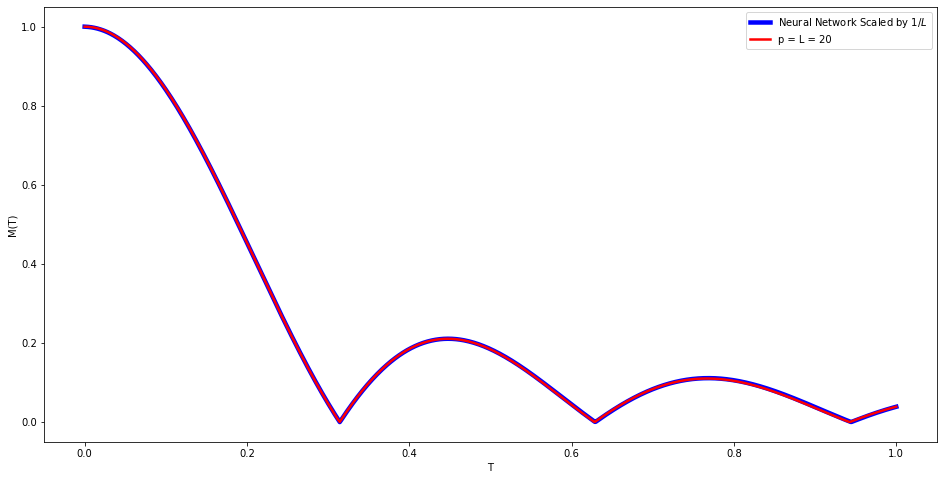

In [7]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(t, h_in/L, color="blue",linewidth=4.5, label="Neural Network Scaled by $1/L$")
plt.xlabel("T")
plt.ylabel("M(T)")
plt.plot(t, np.abs(M_T(L,t)), color="red",linewidth=2.5, label = "p = L = 20")

plt.legend()


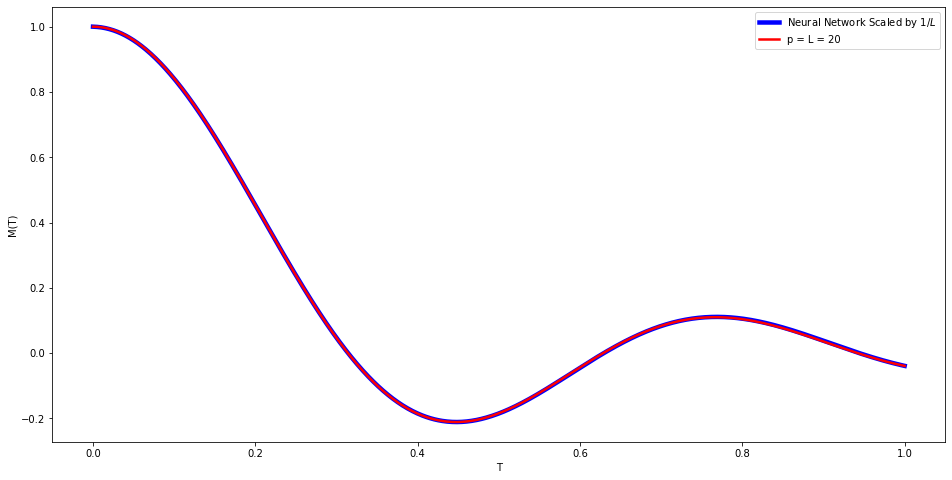

In [8]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(t, u_in/L, color="blue",linewidth=4.5, label="Neural Network Scaled by $1/L$")
plt.xlabel("T")
plt.ylabel("M(T)")
plt.plot(t, M_T(L,t), color="red",linewidth=2.5, label = "p = L = 20")

plt.legend()